# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=222cf39a4f3332af933a9e827c95b633c7fddfeef625a10ada14fa18dca34580
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14678, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 1

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# !dir drive/MyDrive/output/model_final.pth

Mounted at /content/drive/


In [ ]:
!gdown --id 1fSldEVokiupg4udYz73pIBThpqWdy3Hb
!unzip /content/graph_img_private.zip > /dev/null

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fSldEVokiupg4udYz73pIBThpqWdy3Hb
To: /content/graph_img_private.zip
100% 22.3M/22.3M [00:00<00:00, 53.3MB/s]


In [ ]:

!gdown --id 1a-jBVohFTUj-MlWFZWLMoUFNk6UIqS9N
!unzip /content/graph_img_val.zip > /dev/null

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1a-jBVohFTUj-MlWFZWLMoUFNk6UIqS9N
To: /content/graph_img_val.zip
100% 2.48M/2.48M [00:00<00:00, 169MB/s]


In [ ]:
import glob 

# for где читаем все словари json в список
def get_dict_list(dir_name: str):
    file_list = glob.glob(os.path.join(dir_name, '*.json'))
    
    dict_list = []
    for file in file_list:
        with open(file) as f:
            json_file = json.load(f)
            
            filename = json_file['filename'].split("\\")[-1]
            json_file['filename'] = os.path.join(dir_name, filename)
            json_file['file_name'] = json_file.pop('filename')
            
            dict_list.append(json_file)
            
    return dict_list

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [ ]:
# train
dir_name = "/content/graph_img_private"
DatasetCatalog.register("graph_train", lambda dir_name=dir_name: get_dict_list(dir_name))

# val
dir_name = "/content/graph_img_val"
DatasetCatalog.register("graph_val", lambda dir_name=dir_name: get_dict_list(dir_name))

To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:



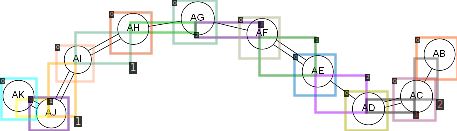

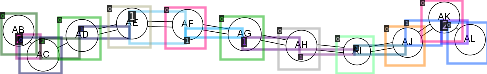

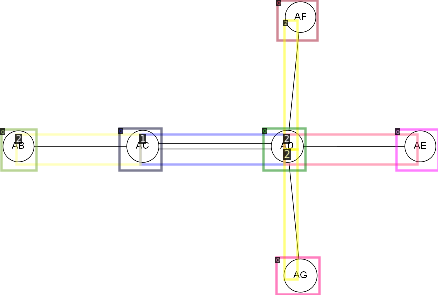

In [ ]:
dataset_dicts = get_dict_list("graph_img_private")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer

# делаем конфиг
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# чутка его меняем под наши нужды
cfg.DATASETS.TRAIN = ("graph_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # edge type 0, edge type 1 and node


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
# обучение
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/17 16:34:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:12, 13.6MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/17 16:35:03 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/17 16:35:18 d2.utils.events]:  eta: 0:04:42  iter: 19  total_loss: 5.452  loss_cls: 1.521  loss_box_reg: 0.8582  loss_rpn_cls: 2.82  loss_rpn_loc: 0.256  time: 0.3018  data_time: 0.0144  lr: 4.9953e-06  max_mem: 2640M
[12/17 16:35:23 d2.utils.events]:  eta: 0:04:13  iter: 39  total_loss: 3.19  loss_cls: 1.359  loss_box_reg: 0.9413  loss_rpn_cls: 0.6832  loss_rpn_loc: 0.2071  time: 0.2824  data_time: 0.0088  lr: 9.9902e-06  max_mem: 2640M
[12/17 16:35:28 d2.utils.events]:  eta: 0:04:01  iter: 59  total_loss: 2.542  loss_cls: 1.187  loss_box_reg: 0.9779  loss_rpn_cls: 0.1845  loss_rpn_loc: 0.1323  time: 0.2702  data_time: 0.0084  lr: 1.4985e-05  max_mem: 2640M
[12/17 16:35:34 d2.utils.events]:  eta: 0:03:48  iter: 79  total_loss: 2.187  loss_cls: 0.9988  loss_box_reg: 0.9626  loss_rpn_cls: 0.1335  loss_rpn_loc: 0.1735  time: 0.2740  data_time: 0.0092  lr: 1.998e-05  max_mem: 2728M
[12/17 16:35:39 d2.utils.events]:  eta: 0:03:45  iter: 99  total_loss: 1.973  loss_cls: 0.8388  loss_box

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.45   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/17 17:14:21 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [ ]:
# Сохраняем папку с выходом обучения

!cp output/ /content/drive/MyDrive -r

Then, we randomly select several samples to visualize the prediction results.

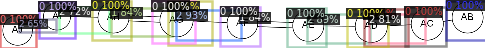

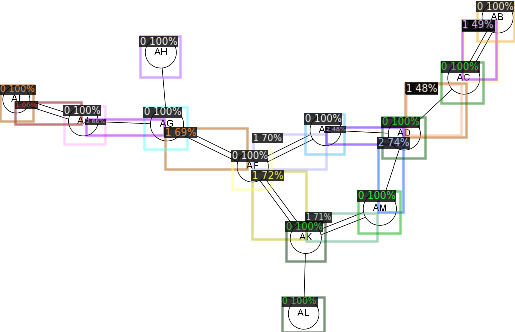

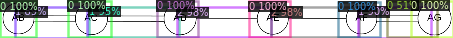

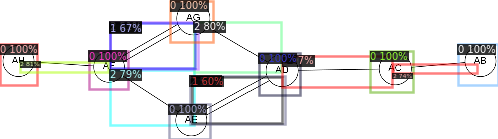

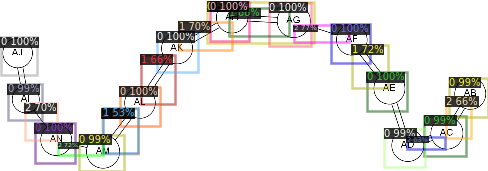

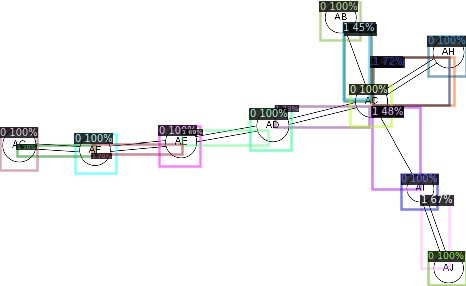

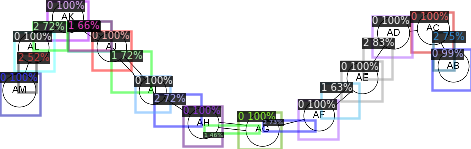

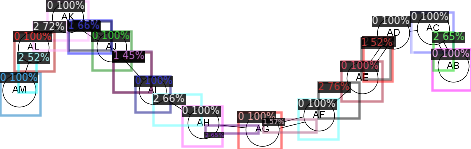

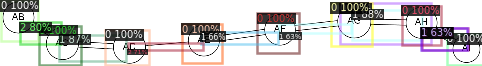

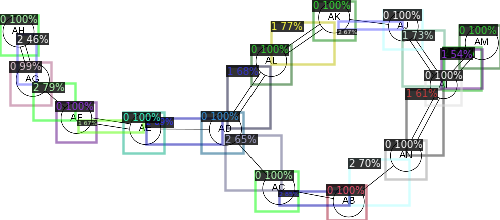

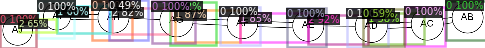

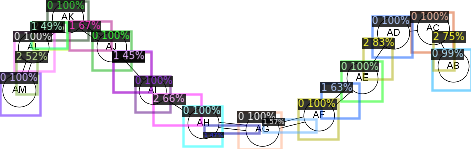

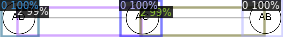

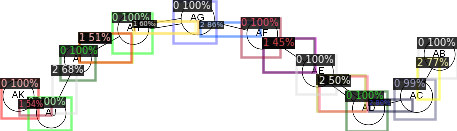

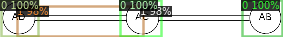

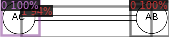

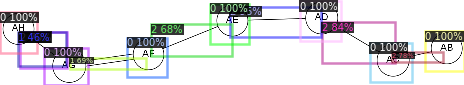

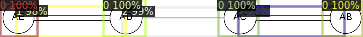

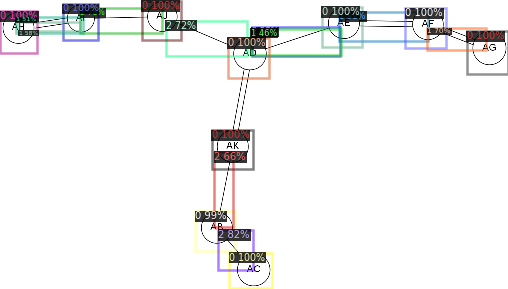

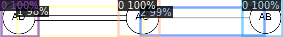

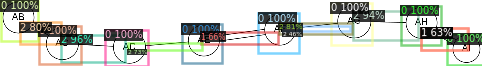

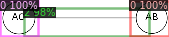

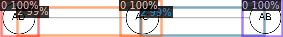

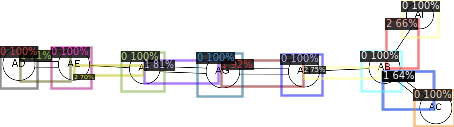

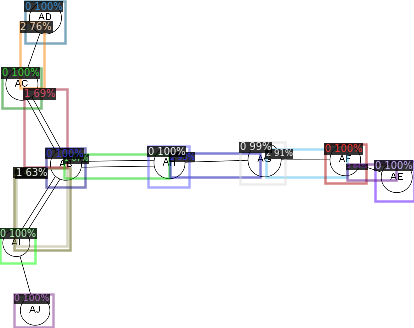

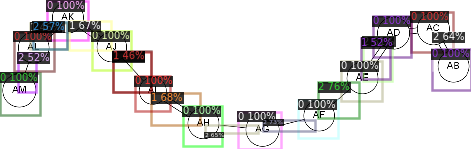

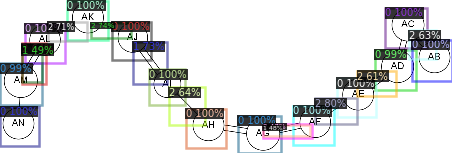

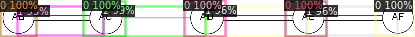

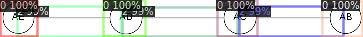

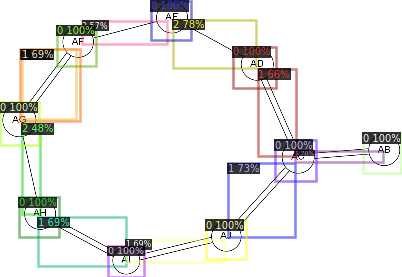

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dict_list("/content/graph_img_val")
for d in random.sample(dataset_dicts, 30):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1], 
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Пример запуска при перезагрузке ноутбука на весах с диска
from google.colab import drive
drive.mount('/content/drive/')

from detectron2.engine import DefaultTrainer

# делаем конфиг
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# чутка его меняем под наши нужды
cfg.DATASETS.TRAIN = ("graph_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = os.path.join('drive/MyDrive/output', "model_final.pth")
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # edge type 1, edge type 2 and node
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.45

predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dict_list("/content/graph_img_val")
for d in random.sample(dataset_dicts, 30):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1], 
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])